In [1]:
import os
import json
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence

In [2]:
# Verificar se a GPU está disponível
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is not available")

GPU is not available


In [3]:
# Diretório onde estão armazenadas as imagens
image_dir = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\dataset'

In [4]:
# Função para carregar e redimensionar as imagens
def load_image(image_path, target_size=(112, 112)):
    try:
        image = Image.open(image_path)
        image = image.resize(target_size)  
        return np.array(image) / 255.0  
    except Exception as e:
        print(f"Erro ao carregar a imagem {image_path}: {e}")
        return None

In [5]:
# Carregar IDs do grupo de treinamento
train_ids_file = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\training_lists\higher_resolution_train.txt'
with open(train_ids_file, 'r') as file:
    train_ids = [str(id) for id in json.loads(file.read())]

In [6]:
# Carregar IDs do grupo de validação
val_ids_file = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\training_lists\higher_resolution_val.txt'
with open(val_ids_file, 'r') as file:
    val_ids = [str(id) for id in json.loads(file.read())]

In [7]:
%%capture
# Listas para armazenar caminhos de imagem e rótulos correspondentes
train_data = []
val_data = []

# Iterar sobre todos os arquivos no diretório
for filename in os.listdir(image_dir):
    if filename.endswith('.json'):
        json_path = os.path.join(image_dir, filename)
        with open(json_path, 'r') as file:
            try:
                json_data = json.load(file)
            except json.JSONDecodeError as e:
                print(f"Erro ao carregar JSON {json_path}: {e}")
                continue
        
        sample_id = str(json_data.get('sample_id', None))
        if sample_id is None:
            print(f"ID da amostra ausente no JSON: {json_path}")
            continue

        image_filename = f"{sample_id}.jpg"
        image_path = os.path.join(image_dir, image_filename)
        if not os.path.exists(image_path):
            print(f"Arquivo de imagem não encontrado: {image_path}")
            continue
        
        classes = json_data.get('classes', [])
        if not classes:
            print(f"Chave 'classes' ausente ou vazia no JSON: {json_path}")
            continue
        
        data_tuple = (image_path, classes[0])
        if sample_id in train_ids:
            train_data.append(data_tuple)
        elif sample_id in val_ids:
            val_data.append(data_tuple)

In [8]:
# Verificar o número de imagens carregadas
print(f"Número de imagens de treinamento carregadas: {len(train_data)}")
print(f"Número de imagens de validação carregadas: {len(val_data)}")

Número de imagens de treinamento carregadas: 5240
Número de imagens de validação carregadas: 1746


In [9]:
# Separar as imagens e os rótulos (labels)
train_images = [data[0] for data in train_data]
train_labels = [data[1] for data in train_data]

val_images = [data[0] for data in val_data]
val_labels = [data[1] for data in val_data]

In [10]:
# Carregar as imagens
train_images = [load_image(image_path, target_size=(112, 112)) for image_path in train_images]
val_images = [load_image(image_path, target_size=(112, 112)) for image_path in val_images]

In [11]:
# Verificar se alguma imagem falhou ao carregar
train_images = [img for img in train_images if img is not None]
val_images = [img for img in val_images if img is not None]

In [12]:
# Converter os rótulos em formato adequado (numérico)
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)

In [13]:
one_hot_encoder = OneHotEncoder(sparse_output=False)

# Ajuste o codificador nos rótulos de treino e transforme-os em one-hot encoding
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1, 1))

# Transforme os rótulos de validação
val_labels_one_hot = one_hot_encoder.transform(val_labels.reshape(-1, 1))

In [14]:
# Definir um gerador de dados personalizado
class DataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size=16, target_size=(112, 112)):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.indices = np.arange(len(self.image_paths))
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [load_image(self.image_paths[i], self.target_size) for i in batch_indices]
        batch_labels = self.labels[batch_indices]
        return np.array(batch_images), np.array(batch_labels)
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)

In [15]:
# Criar geradores para treinamento e validação
train_generator = DataGenerator(train_images, train_labels_one_hot, batch_size=16)
val_generator = DataGenerator(val_images, val_labels_one_hot, batch_size=16)

In [16]:
# Carregar o modelo base VGG16 com pesos pré-treinados da ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(112, 112, 3))

In [17]:
# Congelar as camadas da VGG16 para treinar apenas as camadas personalizadas
base_model.trainable = False

In [18]:
# Adicionar novas camadas no topo do modelo base
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

In [19]:
# Criar o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

In [20]:
# Compilar o modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [56]:
# Treinamento do modelo
history = model.fit(
    np.array(train_images), 
    train_labels_one_hot, 
    epochs=20, 
    batch_size=16, 
    validation_data=(np.array(val_images), val_labels_one_hot)
)

Epoch 1/20
328/328 [==============================] - 222s 670ms/step - loss: 1.7144 - accuracy: 0.2519 - val_loss: 1.4506 - val_accuracy: 0.3992
Epoch 2/20
328/328 [==============================] - 203s 618ms/step - loss: 1.4866 - accuracy: 0.3502 - val_loss: 1.3771 - val_accuracy: 0.4542
Epoch 3/20
328/328 [==============================] - 199s 608ms/step - loss: 1.3984 - accuracy: 0.4181 - val_loss: 1.3289 - val_accuracy: 0.4593
Epoch 4/20
328/328 [==============================] - 199s 606ms/step - loss: 1.3518 - accuracy: 0.4576 - val_loss: 1.2911 - val_accuracy: 0.5304
Epoch 5/20
328/328 [==============================] - 197s 600ms/step - loss: 1.3085 - accuracy: 0.4824 - val_loss: 1.2594 - val_accuracy: 0.5372
Epoch 6/20
328/328 [==============================] - 196s 598ms/step - loss: 1.2760 - accuracy: 0.4966 - val_loss: 1.2317 - val_accuracy: 0.5389
Epoch 7/20
328/328 [==============================] - 195s 594ms/step - loss: 1.2602 - accuracy: 0.5160 - val_loss: 1.2148 -

In [57]:
model.save('trained_model.vgg16_higher_resolution')

INFO:tensorflow:Assets written to: trained_model.vgg16_higher_resolution\assets


INFO:tensorflow:Assets written to: trained_model.vgg16_higher_resolution\assets


In [58]:
# Avaliar no conjunto de validação
val_loss, val_accuracy = model.evaluate(np.array(val_images), val_labels_one_hot)
print(f"Loss no conjunto de validação: {val_loss}")
print(f"Accuracy no conjunto de validação: {val_accuracy}")

55/55 [==============================] - 50s 909ms/step - loss: 1.0676 - accuracy: 0.6140
Loss no conjunto de validação: 1.067598819732666
Accuracy no conjunto de validação: 0.6139748096466064


In [59]:
# Matriz de confusão e relatório de classificação
from sklearn.metrics import confusion_matrix, classification_report

# Obter previsões do modelo
val_predictions = model.predict(np.array(val_images))

# Converter previsões one-hot encoded para rótulos
val_predictions_labels = np.argmax(val_predictions, axis=1)
val_labels_labels = np.argmax(val_labels_one_hot, axis=1)

# Matriz de confusão
conf_matrix = confusion_matrix(val_labels_labels, val_predictions_labels)
print("Matriz de Confusão:")
print(conf_matrix)

# Relatório de classificação
target_names = ['Classe 0', 'Classe 1', 'Classe 2', 'Classe 3', 'Classe 4']
class_report = classification_report(val_labels_labels, val_predictions_labels, target_names=target_names)
print("Relatório de Classificação:")
print(class_report)

55/55 [==============================] - 49s 882ms/step
Matriz de Confusão:
[[ 27  45  39  51  17]
 [  5 251  17  74  21]
 [  9  21 325  68   9]
 [ 10  76  69 300  16]
 [  3  76  16  32 169]]
Relatório de Classificação:
              precision    recall  f1-score   support

    Classe 0       0.50      0.15      0.23       179
    Classe 1       0.54      0.68      0.60       368
    Classe 2       0.70      0.75      0.72       432
    Classe 3       0.57      0.64      0.60       471
    Classe 4       0.73      0.57      0.64       296

    accuracy                           0.61      1746
   macro avg       0.61      0.56      0.56      1746
weighted avg       0.61      0.61      0.60      1746



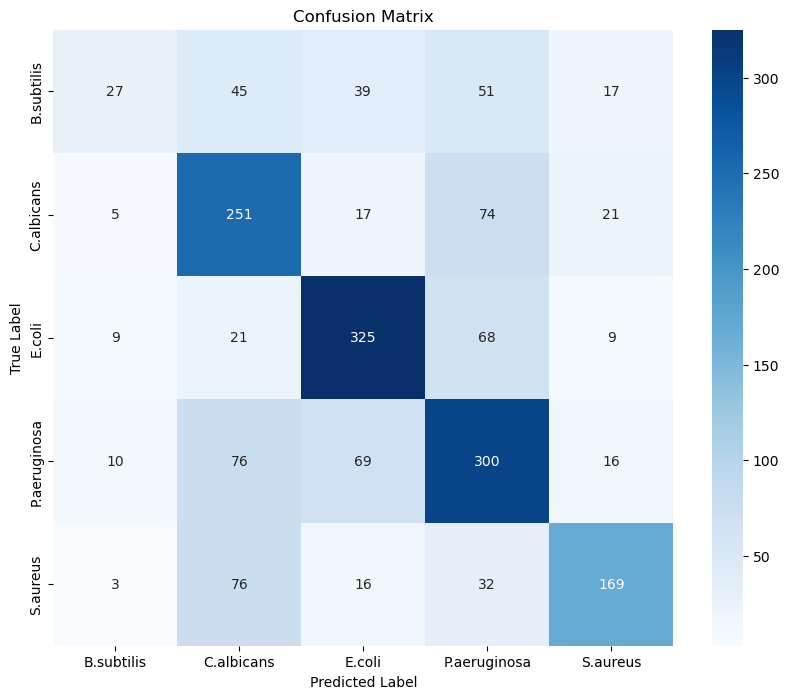

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
# Visualizar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [21]:
# Carregar o modelo salvo
from tensorflow.keras.models import load_model

model_vgg16 = load_model('trained_model.vgg16_higher_resolution')


In [24]:
val_predictions = model.predict(np.array(val_images))
val_predictions_labels = np.argmax(val_predictions, axis=1)
val_labels_labels = np.argmax(val_labels_one_hot, axis=1)

55/55 [==============================] - 48s 842ms/step


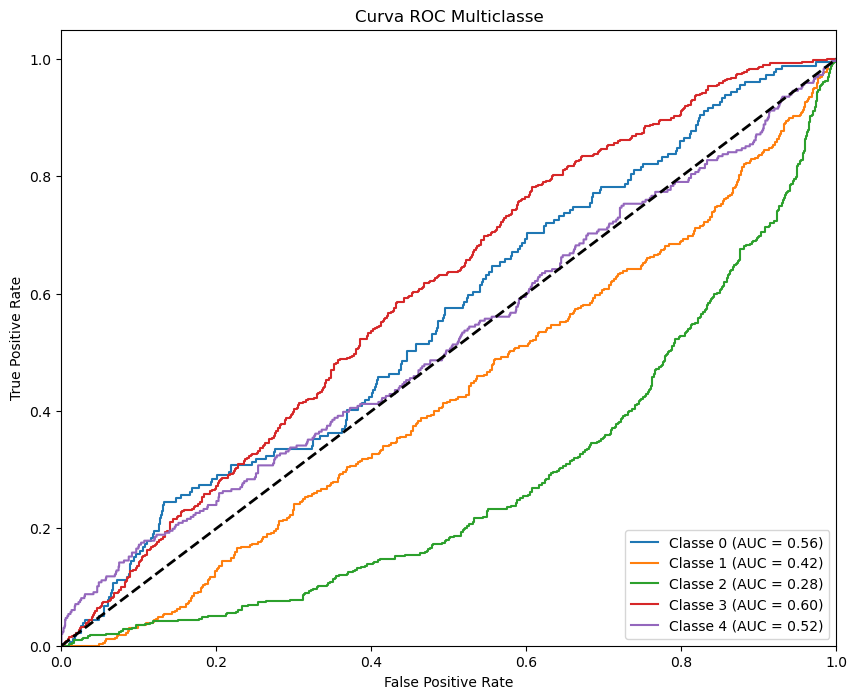

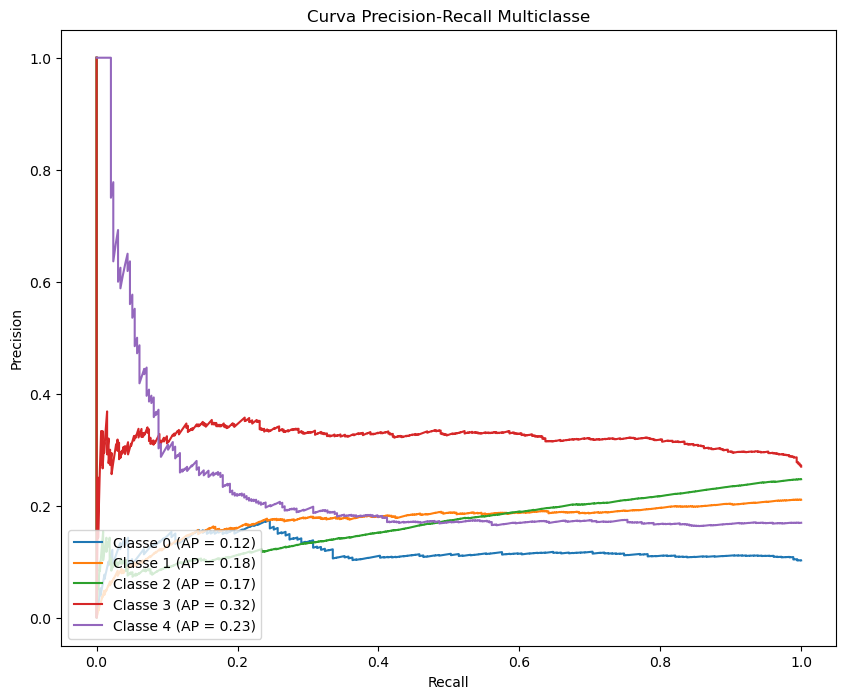

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

def plot_roc_curve(val_labels, val_predictions):
    num_classes = val_labels.shape[1]
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(val_labels[:, i], val_predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC Multiclasse')
    plt.legend(loc="lower right")
    plt.show()

# Função para plotar a curva PRC para cada classe e calcular AP
def plot_prc_curve(val_labels, val_predictions):
    num_classes = val_labels.shape[1]
    precision = {}
    recall = {}
    average_precision = {}

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        precision[i], recall[i], _ = precision_recall_curve(val_labels[:, i], val_predictions[:, i])
        average_precision[i] = average_precision_score(val_labels[:, i], val_predictions[:, i])
        plt.plot(recall[i], precision[i], label=f'Classe {i} (AP = {average_precision[i]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Curva Precision-Recall Multiclasse')
    plt.legend(loc="lower left")
    plt.show()

# Plotar curvas
plot_roc_curve(val_labels_one_hot, val_predictions)
plot_prc_curve(val_labels_one_hot, val_predictions)